# Variational Autoencoder: LeNet-300-100 _full-connected_ with PyTorch and MNIST

- [VAE MNIST CNN VAE](https://www.youtube.com/watch?v=afNuE5z2CQ8)

- [VAE MNIST GitHub reference](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/1_VAE_mnist_sigmoid_mse.ipynb)

- [GitHub helper functions](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/helper_train.py)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Hyper-parameters-
num_epochs = 50
batch_size = 64
learning_rate = 0.001

### MNIST data pre-processing:

#### Compute mean and standard deviation for different datasets

```
import argparse
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms

dataset_names = ('cifar10','cifar100','mnist')

parser = argparse.ArgumentParser(description='PyTorchLab')
parser.add_argument('-d', '--dataset', metavar='DATA', default='cifar10', choices=dataset_names,
                    help='dataset to be used: ' + ' | '.join(dataset_names) + ' (default: cifar10)')

args = parser.parse_args()

data_dir = os.path.join('.', args.dataset)

print(args.dataset)

if args.dataset == "cifar10":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(train_set.train_data.shape)
    print(train_set.train_data.mean(axis=(0,1,2))/255)
    print(train_set.train_data.std(axis=(0,1,2))/255)

elif args.dataset == "cifar100":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.CIFAR100(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(train_set.train_data.shape)
    print(np.mean(train_set.train_data, axis=(0,1,2))/255)
    print(np.std(train_set.train_data, axis=(0,1,2))/255)

elif args.dataset == "mnist":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(list(train_set.train_data.size()))
    print(train_set.train_data.float().mean()/255)
    print(train_set.train_data.float().std()/255)
```

[Reference](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/11)

In [7]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [8]:
path_to_data = "C:\\Users\\arjun\Downloads\\"

In [9]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        # root = './data', train = True,
        root = path_to_data + "data", train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        # root = './data', train = False,
        root = path_to_data + "data", train = False,
        transform = transforms_apply
        )

In [10]:
len(train_dataset.targets), len(train_dataset.data)

(60000, 60000)

In [11]:
len(test_dataset.targets), len(test_dataset.data)

(10000, 10000)

In [12]:
print(f"training dataset length/shape: {list(train_dataset.data.size())}")

training dataset length/shape: [60000, 28, 28]


In [13]:
print(f"mean = {train_dataset.data.float().mean() / 255:.4f}")

mean = 0.1307


In [14]:
print(f"std dev = {train_dataset.data.float().std() / 255:.4f}")

std dev = 0.3081


#### NOTE:

Since MNIST has only one channel, therefore, the mean and standard deviation is computed for one channel!

In [15]:
# Sanity check-
train_dataset.data.min(), train_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [16]:
test_dataset.data.min(), test_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

#### Scale pixel values in the range 0 to 1

To manually convert the pixel values in the range 0 to 1, divide the training and testing datasets by 255.0.

In [17]:
train = train_dataset.data.float() / 255.0
test = test_dataset.data.float() / 255.0

In [18]:
type(train), type(test)

(torch.Tensor, torch.Tensor)

In [19]:
train.shape, test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [20]:
# Reshape to include gray-scale channel-
# train = train.reshape(60000, 1, 28, 28)
# test = test.reshape(10000, 1, 28, 28)

# Reshape the datasets into a flattened shape for LeNet300
# architecture-
train = train.view(-1, 28 * 28 * 1)
test = test.view(-1, 28 * 28 * 1)

In [21]:
# Sanity check-
train.shape, test.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [22]:
# Sanity check- min and max pixel values are in the range 0 to 1-
train.data.min(), train.data.max()

(tensor(0.), tensor(1.))

In [23]:
test.data.min(), test.data.max()

(tensor(0.), tensor(1.))

In [24]:
del train_dataset, test_dataset

In [25]:
print(f"batch size to be used = {batch_size}")

batch size to be used = 64


In [26]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
        dataset = train, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test, batch_size = batch_size,
        shuffle = False
        )

In [27]:
print(f"Sizes of train_dataset: {len(train)} and test_dataet: {len(test)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 938 and test_loader: 157


In [28]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 938 & len(test_loader) = 157


In [29]:
# Sanity check-
len(train) / batch_size, len(test) / batch_size

(937.5, 156.25)

In [30]:
# Get some random batch of training images & labels-
# images, labels = next(iter(train_loader))
images = next(iter(train_loader))

# You get 64 images due to the specified batch size-
# print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")
print(f"images.shape: {images.shape}")

images.shape: torch.Size([64, 784])


In [31]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [32]:
# De-normalize the batch of images-
images *= 255.0

In [33]:
images.min(), images.max()

(tensor(0.), tensor(255.))

In [34]:
# Reshape images for visualization-
images = images.view(-1, 1, 28, 28)

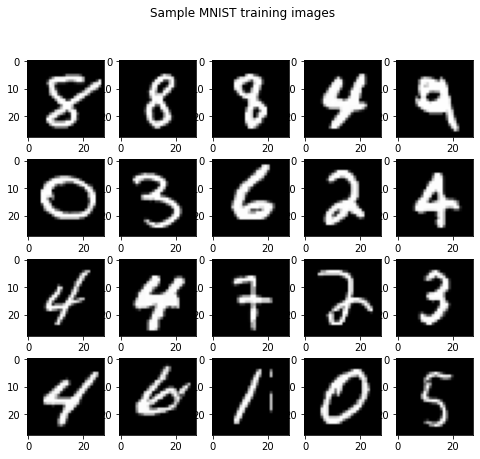

In [35]:
# Visualize 20 images from training set-
plt.figure(figsize = (8, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

In [36]:
del images

### Define Variational Autoencoder architecture using _dense_ layers

In [37]:
class LeNet300_Encoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet300_Encoder, self).__init__()
        self.latent_space = latent_space
        
        # Define layers-
        self.fc1 = nn.Linear(in_features = 28 * 28 * 1, out_features = 300)
        self.fc2 = nn.Linear(in_features = 300, out_features = 100)
        self.encoder_output = nn.Linear(in_features = 100, out_features = self.latent_space)
        
        self.weights_initialization()
    
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.encoder_output(x))
        return x
    
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.fc1(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.fc2(x)
        print(f"dense2 output shape: {x.shape}")
        x = self.encoder_output(x)
        print(f"encoder output shape: {x.shape}")
        del x
        return None
    
    

In [38]:
class LeNet300_Decoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet300_Decoder, self).__init__()
        self.latent_space = latent_space
        
        # Define layers-
        self.fc1 = nn.Linear(in_features = self.latent_space, out_features = 100)
        self.fc2 = nn.Linear(in_features = 100, out_features = 300)
        self.decoder_output = nn.Linear(in_features = 300, out_features = 28 * 28 * 1)
    
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.decoder_output(x)
        return x
    
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # nn.init.kaiming_normal_(m.weight)
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.fc1(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.fc2(x)
        print(f"dense2 output shape: {x.shape}")
        x = self.decoder_output(x)
        print(f"decoder output shape: {x.shape}")
        del x
        return None
    

#### Sanity check

In [39]:
images = next(iter(train_loader))

In [40]:
images.shape

torch.Size([64, 784])

In [41]:
encoder = LeNet300_Encoder(latent_space = 3)

In [42]:
encoded_images = encoder(images)

In [43]:
decoder = LeNet300_Decoder(latent_space = 3)

In [44]:
decoded_images = decoder(encoded_images)

In [45]:
decoded_images.shape, images.shape

(torch.Size([64, 784]), torch.Size([64, 784]))

In [46]:
encoder.shape_computation(images)

Input shape: torch.Size([64, 784])
dense1 output shape: torch.Size([64, 300])
dense2 output shape: torch.Size([64, 100])
encoder output shape: torch.Size([64, 3])


In [47]:
decoder.shape_computation(encoded_images)

Input shape: torch.Size([64, 3])
dense1 output shape: torch.Size([64, 100])
dense2 output shape: torch.Size([64, 300])
decoder output shape: torch.Size([64, 784])


In [48]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [49]:
encoded_images.min(), encoded_images.max()

(tensor(0., grad_fn=<MinBackward1>), tensor(0.6244, grad_fn=<MaxBackward1>))

In [50]:
del encoded_images, decoded_images, encoder, decoder

#### NOTE: The decoder's output should be on the same scale as input

In [51]:
class VAE_Dense(nn.Module):
    def __init__(self, latent_space = 5):
        super(VAE_Dense, self).__init__()
        
        self.latent_space = latent_space
        
        # Encoder-
        self.encoder = LeNet300_Encoder(latent_space = self.latent_space).to(device)
        
        # Two additional layers 'mu' & 'log_var' vectors to convert the bottleneck into
        # μ and σ vectors-
        self.mu = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        self.log_var = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        
        # Decoder-
        self.decoder = LeNet300_Decoder(latent_space = self.latent_space).to(device)
        
        
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        
        The log-var trick allows us to have both positive and negative values instead
        of only having positive values if standard deviation was used. Having both
        positive & negative values is good for the neural network training process.
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' is sampled from a standard normal distribution
        # to add stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        z = mu + (std * eps)
        
        return z
    
    
    def forward(self, x):
        # Encode input data using encoder-
        x = self.encoder(x)
        # NOTE: The line of code above does NOT give us the latent vector!
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        # Decode latent vector using decoder-
        recon_data = torch.sigmoid(self.decoder(z))
        # recon_data = torch.tanh(self.decoder(z))
        
        return recon_data, mu, log_var
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.encoder(x)
        print(f"Encoder output shape: {x.shape}")
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        x = self.decoder(z)
        print(f"Decoder output shape: {x.shape}")
        del x, mu, log_var, z
        return None
    
    

In [52]:
# Initialize a VAE object-
model = VAE_Dense(latent_space = 3).to(device)

In [53]:
print(model)

VAE_Dense(
  (encoder): LeNet300_Encoder(
    (fc1): Linear(in_features=784, out_features=300, bias=True)
    (fc2): Linear(in_features=300, out_features=100, bias=True)
    (encoder_output): Linear(in_features=100, out_features=3, bias=True)
  )
  (mu): Linear(in_features=3, out_features=3, bias=True)
  (log_var): Linear(in_features=3, out_features=3, bias=True)
  (decoder): LeNet300_Decoder(
    (fc1): Linear(in_features=3, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=300, bias=True)
    (decoder_output): Linear(in_features=300, out_features=784, bias=True)
  )
)


In [54]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([300, 784]) has 235200 parameters
layer.shape = torch.Size([300]) has 300 parameters
layer.shape = torch.Size([100, 300]) has 30000 parameters
layer.shape = torch.Size([100]) has 100 parameters
layer.shape = torch.Size([3, 100]) has 300 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([100, 3]) has 300 parameters
layer.shape = torch.Size([100]) has 100 parameters
layer.shape = torch.Size([300, 100]) has 30000 parameters
layer.shape = torch.Size([300]) has 300 parameters
layer.shape = torch.Size([784, 300]) has 235200 parameters
layer.shape = torch.Size([784]) has 784 parameters


In [55]:
print(f"Total number of parameters in VAE Conv model = {tot_params}")

Total number of parameters in VAE Conv model = 532611


In [56]:
# Save trained VAE model's weights-
torch.save(model.state_dict(), 'VAE_LeNet300_MNIST_Random_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 3).to(device)
# loaded_model.load_state_dict(torch.load(VAE_LeNet300_MNIST_Random_Weights.pth', map_location = torch.device('cpu')))

### Initial variance - Sanity check:

Before training the VAE neural network model, there should be some initial variance.

In [57]:
for x in model.mu.parameters():
    print(x.shape, x.nelement())

torch.Size([3, 3]) 9
torch.Size([3]) 3


In [58]:
log_var_wts = model.log_var.weight
mu_wts = model.mu.weight

In [59]:
mu_wts = mu_wts.detach().cpu().numpy()
log_var_wts = log_var_wts.detach().cpu().numpy()

In [60]:
mu_wts.shape, log_var_wts.shape

((3, 3), (3, 3))

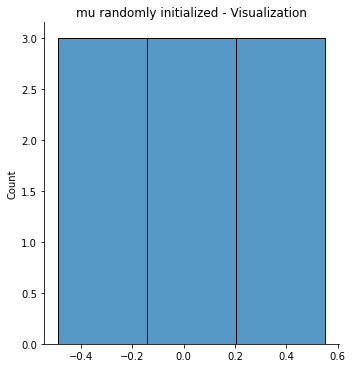

In [61]:
sns.displot(data = mu_wts.flatten(), bins = int(np.ceil(np.sqrt(mu_wts.size))))
plt.title("mu randomly initialized - Visualization")
plt.show()

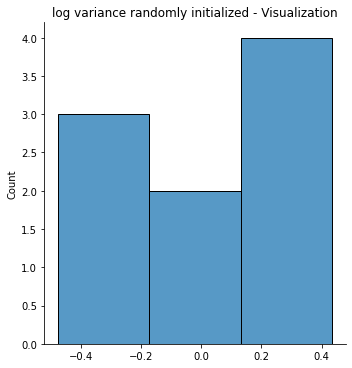

In [62]:
sns.displot(data = log_var_wts.flatten(), bins = int(np.ceil(np.sqrt(log_var_wts.size))))
plt.title("log variance randomly initialized - Visualization")
plt.show()

In [63]:
del mu_wts, log_var_wts

In [64]:
# Sanity check-
images = images.to(device)

In [65]:
images.shape

torch.Size([64, 784])

In [66]:
images.min(), images.max()

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

In [67]:
# Sanity check-
recon_images, mu, log_var = model(images)

In [68]:
recon_images.shape, mu.shape, log_var.shape

(torch.Size([64, 784]), torch.Size([64, 3]), torch.Size([64, 3]))

In [69]:
recon_images.min().detach().cpu().numpy(), recon_images.max().detach().cpu().numpy()

(array(0.31054595, dtype=float32), array(0.70962816, dtype=float32))

In [70]:
del recon_images, mu, log_var

In [71]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [72]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [73]:
def total_loss(data, data_recon, mu, log_var, alpha = 1):
    '''
    Function to compute loss = reconstruction loss * reconstruction_term_weight + KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. mu: mean from the latent vector
    2. logvar: log variance from the latent vector
    3. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss - reconstruction term weight
    4. data: training data
    5. data_recon: VAE's reconstructed data
    '''
    
    # Compute KL-Divergence loss:
    
    # Sum over latent dimensions-
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var), axis = 1)
    # kl_div = -0.5 * torch.sum(1 + log_var - (mu **2) - torch.exp(log_var), axis = 1)
    
    '''
    Omitting 'axis' will give bad results as it will sum over everything!
    First, sum over the latent dimensions and then average over the batches.
    '''
    
    # kl_div.shape
    # torch.Size([64])
    
    batchsize = kl_div.size(0)

    # Compute average KL-divergence over batch size-
    kl_div = kl_div.mean()
    
    
    # Compute Reconstruction loss:
    
    reconstruction_loss_fn = F.mse_loss
    recon_loss = reconstruction_loss_fn(data_recon, data, reduction = 'none')
    
    # recon_loss.shape
    # torch.Size([32, 1, 28, 28])
    
    # Sum over all pixels-
    # Reshape recon_loss so that it is the batchsize and a vector. So, instead
    # of having a tensor, it is now a matrix (table). Then, sum over the pixels.
    # This is equivalent to summing over the latent dimensions for kl_div above.
    # We are summing first the squared error over the pixels and then average over
    # the batch dimensions below-
    recon_loss = recon_loss.view(batchsize, -1).sum(axis = 1)
    
    # recon_loss.shape
    # torch.Size([64, 784])
    
    # Average over mini-batch dimension-
    recon_loss = recon_loss.mean()
    
    final_loss = (alpha * recon_loss) + kl_div
    
    return final_loss, recon_loss, kl_div


In [ ]:
'''
# Sanity check-
final_loss, recon_loss, kl_div_loss = total_loss(
    data = images, data_recon = recon_images,
    mu = mu, log_var = log_var,
    alpha = 1
)
'''

In [ ]:
'''
print(f"final loss = {final_loss.cpu().detach().numpy():.4f},"
      f" reconstruction loss = {recon_loss.cpu().detach().numpy():.4f}"
      f" & kl-div loss = {kl_div_loss.cpu().detach().numpy():.4f}"
     )
'''

In [74]:
def train_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to keep track of 3 losses-
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    
    for i, data in tqdm(
        enumerate(dataloader),
        # total = int(len(train_dataset) / dataloader.batch_size)
        total = int(len(train) / dataloader.batch_size)
        ):
      
        # Ignore labels-
        # data, _ = data

        # Push data points to 'device'-
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        # data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        recon_data, mu, logvar = model(data)
        
        final_loss, recon_loss, kl_div_loss = total_loss(
            data = data, data_recon = recon_data,
            mu = mu, log_var = logvar,
            alpha = alpha
        )
        
        # Update losses-
        running_final_loss += final_loss.item()
        running_kl_loss += kl_div_loss.cpu().detach().numpy()
        running_recon_loss += recon_loss.cpu().detach().numpy()
        
        # Compute gradients wrt total loss-
        final_loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
    
    # Compute losses as float values-
    train_loss = running_final_loss / len(dataloader.dataset)
    kl_loss = running_kl_loss / len(dataloader.dataset)
    recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return train_loss, kl_loss, recon_loss


In [75]:
def validate_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            # total = int(len(test_dataset) / dataloader.batch_size)):
            total = int(len(test) / test_loader.batch_size)):
          
            # Ignore labels-
            # data, _ = data

            # Push data points to 'device'-
            data = data.to(device)
            
            # Flatten data to feed into a dense layer-
            # data = data.view(data.size(0), -1)
            
            # Forward propagation-
            recon_data, mu, logvar = model(data)
            
            final_loss, recon_loss, kl_div_loss = total_loss(
                data = data, data_recon = recon_data,
                mu = mu, log_var = logvar,
                alpha = alpha
            )
        
            # Update losses-
            running_final_loss += final_loss.item()
            running_kl_loss += kl_div_loss.cpu().detach().numpy()
            running_recon_loss += recon_loss.cpu().detach().numpy()
            
                
    val_loss = running_final_loss / len(dataloader.dataset)
    val_kl_loss = running_kl_loss / len(dataloader.dataset)
    val_recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return val_loss, val_kl_loss, val_recon_loss

    

In [ ]:
'''
# Sanity check-
train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
    model = model, dataloader = train_loader,
    alpha = 1
)
'''

In [ ]:
'''
val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
    model = model, dataloader = test_loader,
    alpha = 1
)
'''

In [ ]:
'''
print(f"After one epoch: train loss = {train_loss:.4f}, recon loss = {recon_train_loss:.4f}"
      f" & kl-div loss = {kl_train_loss:.4f}"
     )
'''

In [ ]:
'''
print(f"After one epoch: val train loss = {val_loss:.4f}, val recon loss = {val_recon_loss:.4f}"
      f" & val kl-div loss = {val_kl_loss:.4f}"
     )
'''

### Train VAE model 

#### _alpha_ hyper-parameter

- For LeNet5 CNN, ```alpha = 1``` did not result into __vanishing KL-divergence problem__!

- But, for LeNet-300-100 dense neural network, ```alpha = 1``` results into the __vanishing KL-divergence problem__!

- To fix this, choose appropriate value of ```alpha``` with hyper-parameter tuning and/or heuristic experiments.

In [76]:
# Initialize a VAE objetc-
model = VAE_Dense(latent_space = 3).to(device)

In [77]:
# Save trained VAE model's weights-
torch.save(model.state_dict(), 'VAE_LeNet300_MNIST_Random_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 3).to(device)
# loaded_model.load_state_dict(torch.load(VAE_LeNet300_MNIST_Random_Weights.pth', map_location = torch.device('cpu')))

In [76]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 28 * 28

In [77]:
# Python dict to contain training metrics-
train_history = {}

In [78]:
print(f"Training VAE model for {num_epochs} epochs")

Training VAE model for 50 epochs


In [ ]:
# Initialize parameters for Early Stopping manual implementation-
# best_val_loss = 10000
# loc_patience = 0

In [ ]:
# User input parameters for Early Stopping in manual implementation-
# minimum_delta = 0.001
# patience = 3

In [79]:
for epoch in range(1, num_epochs + 1):
    '''
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    '''
    
    # Train model for 1 epoch-
    train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
        model = model, dataloader = train_loader,
        alpha = alpha
    )
    
    # Get validation after 1 epoch-
    val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
        model = model, dataloader = test_loader,
        alpha = alpha
    )
    
    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss,
        'train_recon_loss': kl_train_loss,
        'train_kl_loss': kl_train_loss,
        'val_loss': val_loss,
        'val_recon_loss': val_recon_loss,
        'val_kl_loss': val_kl_loss
    }
    
    print(f"Epoch = {epoch}; train loss = {train_loss:.4f}",
          f", kl-loss = {kl_train_loss:.4f}, recon loss = {recon_train_loss:.4f}",
          f", val loss = {val_loss:.4f}, val kl-loss = {val_kl_loss:.4f}",
          f" & val recon loss = {val_recon_loss:.4f}"
         )
    
    '''
    # Code for manual Early Stopping:
    if (val_epoch_loss < best_val_loss) and \
    (np.abs(val_epoch_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VAE_LeNet5_MNIST_best_model.pth")
        
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    '''
    
    

938it [00:03, 301.93it/s]                                                                                              
157it [00:00, 981.03it/s]                                                                                              


Epoch = 1; train loss = 481.4621 , kl-loss = 1.2966, recon loss = 0.6125 , val loss = 397.5299, val kl-loss = 1.4092  & val recon loss = 0.5053


938it [00:02, 319.08it/s]                                                                                              
157it [00:00, 1019.25it/s]                                                                                             


Epoch = 2; train loss = 372.5717 , kl-loss = 1.3505, recon loss = 0.4735 , val loss = 356.8796, val kl-loss = 1.2537  & val recon loss = 0.4536


938it [00:03, 309.50it/s]                                                                                              
157it [00:00, 896.94it/s]                                                                                              


Epoch = 3; train loss = 345.9315 , kl-loss = 1.2029, recon loss = 0.4397 , val loss = 337.5854, val kl-loss = 1.1823  & val recon loss = 0.4291


938it [00:03, 248.73it/s]                                                                                              
157it [00:00, 800.84it/s]                                                                                              


Epoch = 4; train loss = 331.5108 , kl-loss = 1.1131, recon loss = 0.4214 , val loss = 327.9907, val kl-loss = 1.0563  & val recon loss = 0.4170


938it [00:03, 289.30it/s]                                                                                              
157it [00:00, 488.99it/s]                                                                                              


Epoch = 5; train loss = 322.4081 , kl-loss = 1.0327, recon loss = 0.4099 , val loss = 320.7483, val kl-loss = 0.9350  & val recon loss = 0.4079


938it [00:03, 291.30it/s]                                                                                              
157it [00:00, 962.98it/s]                                                                                              


Epoch = 6; train loss = 315.8823 , kl-loss = 0.9516, recon loss = 0.4017 , val loss = 317.1561, val kl-loss = 0.9120  & val recon loss = 0.4034


938it [00:03, 292.68it/s]                                                                                              
157it [00:00, 902.09it/s]                                                                                              


Epoch = 7; train loss = 310.7653 , kl-loss = 0.8944, recon loss = 0.3952 , val loss = 312.6617, val kl-loss = 0.8490  & val recon loss = 0.3977


938it [00:03, 254.58it/s]                                                                                              
157it [00:00, 733.85it/s]                                                                                              


Epoch = 8; train loss = 306.7767 , kl-loss = 0.8497, recon loss = 0.3902 , val loss = 309.4021, val kl-loss = 0.8235  & val recon loss = 0.3936


938it [00:03, 293.89it/s]                                                                                              
157it [00:00, 962.97it/s]                                                                                              


Epoch = 9; train loss = 303.0000 , kl-loss = 0.8096, recon loss = 0.3854 , val loss = 306.9666, val kl-loss = 0.7542  & val recon loss = 0.3906


938it [00:03, 274.85it/s]                                                                                              
157it [00:00, 713.45it/s]                                                                                              


Epoch = 10; train loss = 300.3059 , kl-loss = 0.7794, recon loss = 0.3820 , val loss = 304.6019, val kl-loss = 0.7386  & val recon loss = 0.3876


938it [00:03, 289.64it/s]                                                                                              
157it [00:00, 856.65it/s]                                                                                              


Epoch = 11; train loss = 297.8953 , kl-loss = 0.7514, recon loss = 0.3790 , val loss = 303.3437, val kl-loss = 0.7173  & val recon loss = 0.3860


938it [00:03, 278.48it/s]                                                                                              
157it [00:00, 968.91it/s]                                                                                              


Epoch = 12; train loss = 295.3636 , kl-loss = 0.7339, recon loss = 0.3758 , val loss = 302.3492, val kl-loss = 0.6901  & val recon loss = 0.3848


938it [00:03, 288.43it/s]                                                                                              
157it [00:00, 720.02it/s]                                                                                              


Epoch = 13; train loss = 293.4916 , kl-loss = 0.7236, recon loss = 0.3734 , val loss = 301.5064, val kl-loss = 0.7207  & val recon loss = 0.3837


938it [00:03, 296.88it/s]                                                                                              
157it [00:00, 934.31it/s]                                                                                              


Epoch = 14; train loss = 291.4550 , kl-loss = 0.7028, recon loss = 0.3709 , val loss = 298.2057, val kl-loss = 0.6763  & val recon loss = 0.3795


938it [00:03, 287.95it/s]                                                                                              
157it [00:00, 761.96it/s]                                                                                              


Epoch = 15; train loss = 289.6307 , kl-loss = 0.6867, recon loss = 0.3686 , val loss = 297.8306, val kl-loss = 0.6649  & val recon loss = 0.3790


938it [00:03, 289.93it/s]                                                                                              
157it [00:00, 907.31it/s]                                                                                              


Epoch = 16; train loss = 288.2365 , kl-loss = 0.6774, recon loss = 0.3668 , val loss = 295.7163, val kl-loss = 0.6452  & val recon loss = 0.3764


938it [00:03, 287.26it/s]                                                                                              
157it [00:00, 896.94it/s]                                                                                              


Epoch = 17; train loss = 286.6049 , kl-loss = 0.6629, recon loss = 0.3647 , val loss = 295.4102, val kl-loss = 0.6387  & val recon loss = 0.3760


938it [00:03, 269.82it/s]                                                                                              
157it [00:00, 934.32it/s]                                                                                              


Epoch = 18; train loss = 285.1541 , kl-loss = 0.6511, recon loss = 0.3629 , val loss = 293.4317, val kl-loss = 0.6356  & val recon loss = 0.3735


938it [00:03, 280.51it/s]                                                                                              
157it [00:00, 962.97it/s]                                                                                              


Epoch = 19; train loss = 284.3421 , kl-loss = 0.6421, recon loss = 0.3619 , val loss = 292.9355, val kl-loss = 0.6157  & val recon loss = 0.3729


938it [00:03, 278.94it/s]                                                                                              
157it [00:00, 976.15it/s]                                                                                              


Epoch = 20; train loss = 282.7154 , kl-loss = 0.6332, recon loss = 0.3598 , val loss = 292.6961, val kl-loss = 0.6057  & val recon loss = 0.3726


938it [00:03, 279.12it/s]                                                                                              
157it [00:00, 945.57it/s]                                                                                              


Epoch = 21; train loss = 281.6745 , kl-loss = 0.6254, recon loss = 0.3585 , val loss = 291.9045, val kl-loss = 0.5900  & val recon loss = 0.3716


938it [00:03, 276.56it/s]                                                                                              
157it [00:00, 699.66it/s]                                                                                              


Epoch = 22; train loss = 280.7073 , kl-loss = 0.6185, recon loss = 0.3573 , val loss = 292.8337, val kl-loss = 0.6059  & val recon loss = 0.3727


938it [00:03, 290.35it/s]                                                                                              
157it [00:00, 912.59it/s]                                                                                              


Epoch = 23; train loss = 279.8470 , kl-loss = 0.6116, recon loss = 0.3562 , val loss = 290.2334, val kl-loss = 0.5940  & val recon loss = 0.3694


938it [00:03, 281.30it/s]                                                                                              
157it [00:00, 737.81it/s]                                                                                              


Epoch = 24; train loss = 279.0679 , kl-loss = 0.6077, recon loss = 0.3552 , val loss = 291.5391, val kl-loss = 0.5739  & val recon loss = 0.3711


938it [00:03, 293.88it/s]                                                                                              
157it [00:00, 928.78it/s]                                                                                              


Epoch = 25; train loss = 278.1673 , kl-loss = 0.5950, recon loss = 0.3540 , val loss = 290.3105, val kl-loss = 0.5797  & val recon loss = 0.3696


938it [00:03, 286.48it/s]                                                                                              
157it [00:00, 821.80it/s]                                                                                              


Epoch = 26; train loss = 277.5552 , kl-loss = 0.5968, recon loss = 0.3533 , val loss = 289.5265, val kl-loss = 0.5668  & val recon loss = 0.3686


938it [00:03, 290.65it/s]                                                                                              
157it [00:00, 939.91it/s]                                                                                              


Epoch = 27; train loss = 276.3813 , kl-loss = 0.5881, recon loss = 0.3518 , val loss = 289.2230, val kl-loss = 0.5547  & val recon loss = 0.3682


938it [00:03, 284.61it/s]                                                                                              
157it [00:00, 902.10it/s]                                                                                              


Epoch = 28; train loss = 275.5168 , kl-loss = 0.5824, recon loss = 0.3507 , val loss = 289.2921, val kl-loss = 0.5714  & val recon loss = 0.3683


938it [00:03, 280.34it/s]                                                                                              
157it [00:00, 800.84it/s]                                                                                              


Epoch = 29; train loss = 274.8191 , kl-loss = 0.5795, recon loss = 0.3498 , val loss = 289.8854, val kl-loss = 0.5520  & val recon loss = 0.3690


938it [00:03, 278.89it/s]                                                                                              
157it [00:00, 843.90it/s]                                                                                              


Epoch = 30; train loss = 274.2736 , kl-loss = 0.5721, recon loss = 0.3491 , val loss = 289.3956, val kl-loss = 0.5479  & val recon loss = 0.3684


938it [00:03, 266.99it/s]                                                                                              
157it [00:00, 945.57it/s]                                                                                              


Epoch = 31; train loss = 273.7486 , kl-loss = 0.5701, recon loss = 0.3484 , val loss = 288.6970, val kl-loss = 0.5408  & val recon loss = 0.3675


938it [00:03, 263.42it/s]                                                                                              
157it [00:00, 912.58it/s]                                                                                              


Epoch = 32; train loss = 273.2456 , kl-loss = 0.5637, recon loss = 0.3478 , val loss = 288.5041, val kl-loss = 0.5475  & val recon loss = 0.3673


938it [00:03, 268.58it/s]                                                                                              
157it [00:00, 703.87it/s]                                                                                              


Epoch = 33; train loss = 272.6459 , kl-loss = 0.5612, recon loss = 0.3470 , val loss = 288.9095, val kl-loss = 0.5346  & val recon loss = 0.3678


938it [00:03, 273.47it/s]                                                                                              
157it [00:00, 999.78it/s]                                                                                              


Epoch = 34; train loss = 272.1348 , kl-loss = 0.5566, recon loss = 0.3464 , val loss = 288.5462, val kl-loss = 0.5359  & val recon loss = 0.3674


938it [00:03, 268.14it/s]                                                                                              
157it [00:00, 968.91it/s]                                                                                              


Epoch = 35; train loss = 271.4749 , kl-loss = 0.5531, recon loss = 0.3456 , val loss = 287.8767, val kl-loss = 0.5297  & val recon loss = 0.3665


938it [00:03, 273.90it/s]                                                                                              
157it [00:00, 754.63it/s]                                                                                              


Epoch = 36; train loss = 270.6159 , kl-loss = 0.5484, recon loss = 0.3445 , val loss = 286.6024, val kl-loss = 0.5334  & val recon loss = 0.3649


938it [00:03, 267.53it/s]                                                                                              
157it [00:00, 934.31it/s]                                                                                              


Epoch = 37; train loss = 270.2494 , kl-loss = 0.5465, recon loss = 0.3440 , val loss = 287.0680, val kl-loss = 0.5244  & val recon loss = 0.3655


938it [00:03, 285.70it/s]                                                                                              
157it [00:00, 934.30it/s]                                                                                              


Epoch = 38; train loss = 270.0238 , kl-loss = 0.5405, recon loss = 0.3437 , val loss = 287.8359, val kl-loss = 0.5235  & val recon loss = 0.3665


938it [00:03, 287.25it/s]                                                                                              
157it [00:00, 962.97it/s]                                                                                              


Epoch = 39; train loss = 269.0550 , kl-loss = 0.5395, recon loss = 0.3425 , val loss = 286.6843, val kl-loss = 0.5322  & val recon loss = 0.3650


938it [00:03, 272.39it/s]                                                                                              
157it [00:00, 957.10it/s]                                                                                              


Epoch = 40; train loss = 268.6615 , kl-loss = 0.5425, recon loss = 0.3420 , val loss = 286.4858, val kl-loss = 0.5265  & val recon loss = 0.3647


938it [00:03, 280.01it/s]                                                                                              
157it [00:00, 876.90it/s]                                                                                              


Epoch = 41; train loss = 268.3061 , kl-loss = 0.5354, recon loss = 0.3415 , val loss = 287.8109, val kl-loss = 0.5206  & val recon loss = 0.3664


938it [00:03, 262.83it/s]                                                                                              
157it [00:00, 876.90it/s]                                                                                              


Epoch = 42; train loss = 268.1376 , kl-loss = 0.5362, recon loss = 0.3413 , val loss = 286.7589, val kl-loss = 0.5271  & val recon loss = 0.3651


938it [00:03, 280.98it/s]                                                                                              
157it [00:00, 886.80it/s]                                                                                              


Epoch = 43; train loss = 267.5880 , kl-loss = 0.5345, recon loss = 0.3406 , val loss = 287.1043, val kl-loss = 0.5221  & val recon loss = 0.3655


938it [00:03, 270.85it/s]                                                                                              
157it [00:00, 773.22it/s]                                                                                              


Epoch = 44; train loss = 267.1992 , kl-loss = 0.5313, recon loss = 0.3401 , val loss = 287.2163, val kl-loss = 0.5165  & val recon loss = 0.3657


938it [00:03, 293.06it/s]                                                                                              
157it [00:00, 804.95it/s]                                                                                              


Epoch = 45; train loss = 266.6440 , kl-loss = 0.5300, recon loss = 0.3394 , val loss = 286.2481, val kl-loss = 0.5239  & val recon loss = 0.3644


938it [00:03, 274.24it/s]                                                                                              
157it [00:00, 912.59it/s]                                                                                              


Epoch = 46; train loss = 266.4242 , kl-loss = 0.5272, recon loss = 0.3392 , val loss = 285.9616, val kl-loss = 0.5080  & val recon loss = 0.3641


938it [00:03, 288.86it/s]                                                                                              
157it [00:00, 826.13it/s]                                                                                              


Epoch = 47; train loss = 265.9534 , kl-loss = 0.5248, recon loss = 0.3386 , val loss = 285.8030, val kl-loss = 0.5132  & val recon loss = 0.3639


938it [00:03, 292.09it/s]                                                                                              
157it [00:00, 665.11it/s]                                                                                              


Epoch = 48; train loss = 265.3540 , kl-loss = 0.5254, recon loss = 0.3378 , val loss = 287.2914, val kl-loss = 0.5110  & val recon loss = 0.3658


938it [00:04, 188.38it/s]                                                                                              
157it [00:00, 974.93it/s]                                                                                              


Epoch = 49; train loss = 265.1163 , kl-loss = 0.5259, recon loss = 0.3375 , val loss = 286.2323, val kl-loss = 0.5152  & val recon loss = 0.3644


938it [00:03, 298.09it/s]                                                                                              
157it [00:00, 853.07it/s]                                                                                              

Epoch = 50; train loss = 264.9378 , kl-loss = 0.5256, recon loss = 0.3373 , val loss = 285.6771, val kl-loss = 0.5098  & val recon loss = 0.3637


### Visualize Training metrics

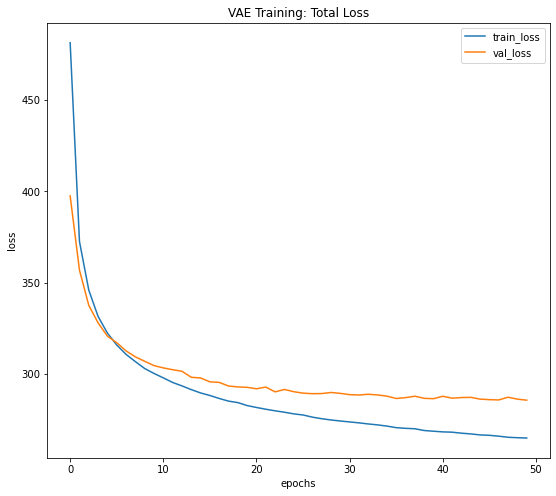

In [80]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'train_loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Total Loss")
plt.show()

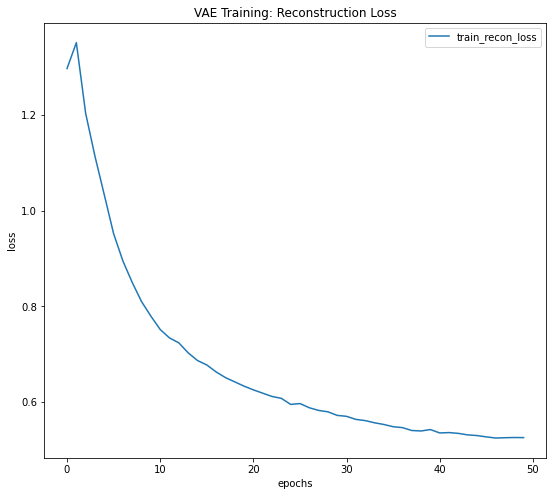

In [81]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_recon_loss'] for e in train_history.keys()], label = 'train_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Reconstruction Loss")
plt.show()

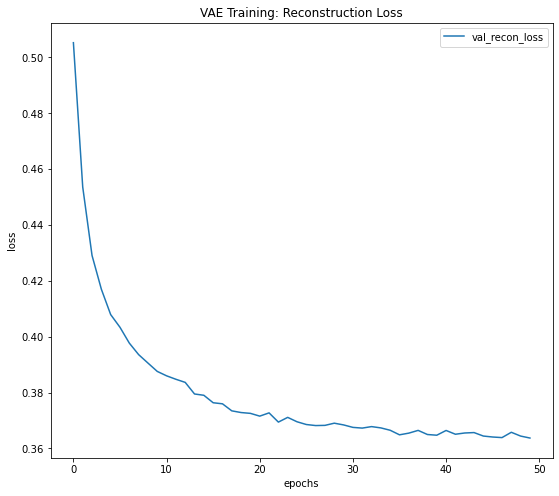

In [82]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['val_recon_loss'] for e in train_history.keys()], label = 'val_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Reconstruction Loss")
plt.show()

_Reconstruction loss_ has 2 plots since training and validation losses are on different scales.

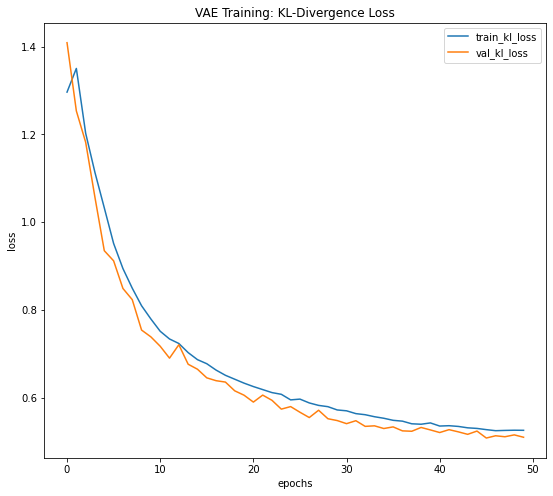

In [83]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_kl_loss'] for e in train_history.keys()], label = 'train_kl_loss')
plt.plot([train_history[e]['val_kl_loss'] for e in train_history.keys()], label = 'val_kl_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: KL-Divergence Loss")
plt.show()

In [84]:
# Save trained VAE model's weights-
torch.save(model.state_dict(), 'VAE_LeNet300_MNIST_Trained_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 3).to(device)
# loaded_model.load_state_dict(torch.load('VAE_LeNet300_MNIST_Trained_Weights.pth', map_location = torch.device('cpu')))

In [ ]:
# Define gradient descent optimizer-
# optimizer = torch.optim.Adam(loaded_model.parameters(), lr = learning_rate)

In [85]:
import pickle

# Save training history as pickle file-
with open("VAE_LeNet300_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_LeNet300_MNIST_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

### Reconstruct/Generate images using _trained_ VAE model

In [86]:
images = next(iter(train_loader))

In [87]:
images = images.to(device)

In [88]:
images_recon, mu, log_var = model(images)

In [89]:
images.shape, images_recon.shape

(torch.Size([64, 784]), torch.Size([64, 784]))

In [90]:
mu.shape, log_var.shape

(torch.Size([64, 3]), torch.Size([64, 3]))

In [91]:
images_recon = images_recon.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()
log_var = log_var.cpu().detach().numpy()

In [92]:
images = images.cpu().detach().numpy()

In [93]:
images.shape, images_recon.shape

((64, 784), (64, 784))

In [94]:
# Reshape for visualization-
images = images.reshape(-1, 784)
images_recon = images_recon.reshape(-1, 784)

In [95]:
images = images.reshape(-1, 1, 28, 28)
images_recon = images_recon.reshape(-1, 1, 28, 28)

In [96]:
np.transpose(images, (0, 2, 3, 1)).shape

(64, 28, 28, 1)

In [97]:
np.transpose(images_recon, (0, 2, 3, 1)).shape

(64, 28, 28, 1)

In [98]:
images = np.transpose(images, (0, 2, 3, 1))

In [99]:
images_recon = np.transpose(images_recon, (0, 2, 3, 1))

In [100]:
images.shape, images_recon.shape

((64, 28, 28, 1), (64, 28, 28, 1))

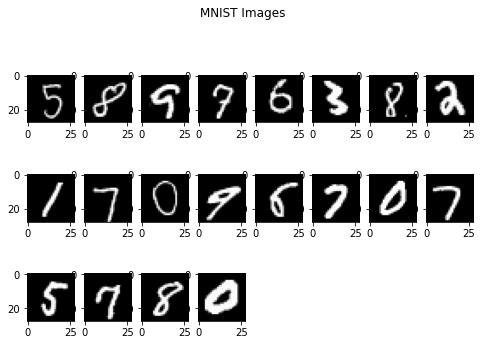

In [101]:
# Visualize 32 images from training set-
plt.figure(figsize = (8, 7))
for i in range(20):
    # 4 rows and 8 columns-
    plt.subplot(4, 8, i + 1)
    plt.imshow(images[i], cmap = 'gray')

plt.suptitle("MNIST Images")
plt.show()

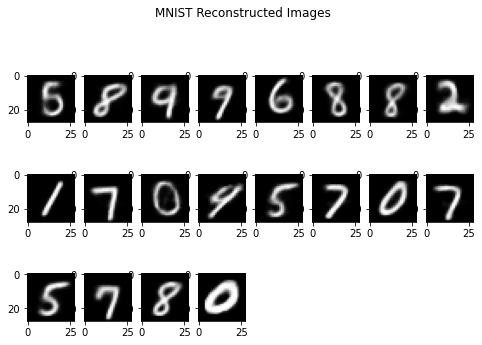

In [102]:
# Visualize 32 reconstructed images-
plt.figure(figsize = (8, 7))
for i in range(20):
    # 4 rows and 8 columns-
    plt.subplot(4, 8, i + 1)
    plt.imshow(images_recon[i], cmap = 'gray')

plt.suptitle("MNIST Reconstructed Images")
plt.show()

In [103]:
del images, images_recon, mu, log_var

In [104]:
train.shape

torch.Size([60000, 784])

In [105]:
train = train.to(device)

In [106]:
_, mu, log_var = model(train)

In [107]:
mu.shape, log_var.shape

(torch.Size([60000, 3]), torch.Size([60000, 3]))

In [108]:
train.shape

torch.Size([60000, 784])

In [109]:
mu = mu.cpu().detach().numpy()
log_var = log_var.cpu().detach().numpy()

In [110]:
train = train.cpu().detach()

In [111]:
# Sanity check-
mu.shape, log_var.shape

((60000, 3), (60000, 3))

In [112]:
train.shape

torch.Size([60000, 784])

### Visualize _mu_ & _log_var_ trained vectors

In [113]:
import plotly
import plotly.express as px

In [ ]:
# Visualize latent space for 'mu' vector-
fig = px.scatter_3d(
    x = mu[:, 0], y = mu[:, 1],
    z = mu[:, 2],
    # color = y_train
    )
fig.show()

In [ ]:
# Visualize latent space for 'log variance' vector-
fig = px.scatter_3d(
    x = log_var[:, 0], y = log_var[:, 1],
    z = log_var[:, 2],
    # color = y_train
    )
fig.show()

In [116]:
print(f"Mean vector (mu): mean = {mu.mean():4f} & std dev = {mu.std():.4f}")

Mean vector (mu): mean = 0.594813 & std dev = 3.5165


In [117]:
print(f"log-variance (log-var): mean = {log_var.mean():.4f} & std dev = {log_var.std():.4f}")

log-variance (log-var): mean = -10.6344 & std dev = 1.0273


In [118]:
np.sum(mu, axis = 0)

array([ 158932.33,   49853.36, -101719.81], dtype=float32)

In [119]:
np.sum(log_var, axis = 0)

array([-645438.1 , -631807.56, -636951.  ], dtype=float32)

In [120]:
train = train.to(device)

In [121]:
train_encoded = model.encoder(train)

In [122]:
train = train.cpu().detach()
train_encoded = train_encoded.cpu().detach().numpy()

In [123]:
train.shape, train_encoded.shape

(torch.Size([60000, 784]), (60000, 3))

In [124]:
for i in range(3):
    print(f"lv = {i + 1}: mean = {train_encoded[:, i].mean():.4f} & std dev ="
          f" {train_encoded[:, i].std():.4f}"
         )

lv = 1: mean = 16.0851 & std dev = 9.0970
lv = 2: mean = 10.7505 & std dev = 5.9430
lv = 3: mean = 12.3705 & std dev = 6.4443


In [125]:
train_encoded = torch.tensor(train_encoded).to(device)

In [126]:
z = model.mu(train_encoded) + model.log_var(train_encoded)

In [127]:
z = z.cpu().detach().numpy()
train_encoded = train_encoded.cpu().detach().numpy()

In [128]:
mu.shape, log_var.shape, z.shape

((60000, 3), (60000, 3), (60000, 3))

In [129]:
mu.min(), mu.max()

(-16.83474, 16.982918)

In [130]:
log_var.min(), log_var.max()

(-18.180424, -7.993333)

In [131]:
z.min(), z.max()

(-31.38552, 5.614538)

In [132]:
z.mean(), z.std()

(-10.039625, 3.457062)

In [134]:
for i in range(3):
    print(f"lv = {i + 1}: min = {z[:, i].min():.4f} & max = {z[:, i].max():.4f}")

lv = 1: min = -16.8894 & max = 5.6145
lv = 2: min = -26.5813 & max = 3.1853
lv = 3: min = -31.3855 & max = -0.2336


In [ ]:
# Visualize encoded space for all training images-
fig = px.scatter_3d(
    x = z[:, 0], y = z[:, 1],
    z = z[:, 2],
    # color = y_train
    )
fig.show()

In [151]:
z[:2, :].shape

(2, 3)

In [152]:
z[:2, :]

array([[ -6.6833634, -11.151882 , -12.127437 ],
       [ -3.2855802,  -9.503002 ,  -8.816118 ]], dtype=float32)

In [180]:
random_point = torch.tensor(
    [
        [0.0, 0.0, 0.0],
        [0.1, 0.5, -0.9]
    ]
)

In [155]:
# Returns a tensor filled with random numbers sampled from a normal distribution-
random_point = torch.randn(2, 3)

In [181]:
random_point.to(device)

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.1000,  0.5000, -0.9000]], device='cuda:0')

In [182]:
random_point.shape

torch.Size([2, 3])

In [184]:
# random_recon = model.decoder(random_point)

In [162]:
z = torch.tensor(z)

In [163]:
z = z.to(device)

In [167]:
# random_recon = model.decoder(random_point)
z_recon = model.decoder(z[:2, :])

In [169]:
z_recon = z_recon.cpu().detach().numpy()

In [170]:
z_recon.shape

(2, 784)

In [171]:
z_recon = z_recon.reshape(-1, 1, 28, 28)

In [174]:
z_recon = np.transpose(z_recon, (0, 2, 3, 1))

In [175]:
z_recon.shape

(2, 28, 28, 1)

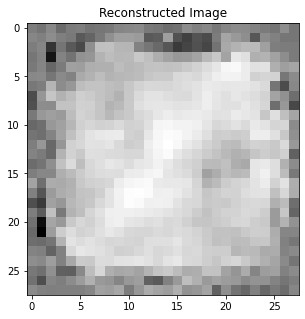

In [178]:
plt.figure(figsize = (6, 5))
plt.imshow(z_recon[0], cmap = 'gray')
plt.title("Reconstructed Image")
plt.show()

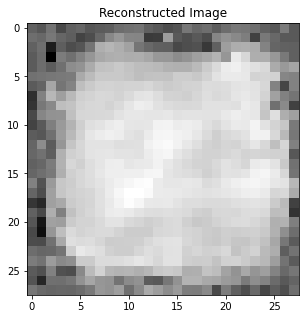

In [179]:
plt.figure(figsize = (6, 5))
plt.imshow(z_recon[1], cmap = 'gray')
plt.title("Reconstructed Image")
plt.show()

### Save _encoded_ representation for training data

In [141]:
with open('MNIST_LeNet300_z.npy', 'wb') as file:
    np.save(file, z)

In [ ]:
"""
with open('MNIST_LeNet300_z.npy', 'rb') as file:
    z_encoded = np.load(file)
"""